In [2]:
# import library
import tensorflow as tf
import numpy as np
import sys, os,cv2
from scipy.misc import imread,imresize
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from imgaug import augmenters as iaa
import imgaug as ia
from scipy.ndimage import zoom
from sklearn.utils import shuffle
import matplotlib.animation as animation
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_blobs,make_moons,make_swiss_roll
from IPython.display  import IFrame

plt.style.use('seaborn')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

sess = tf.InteractiveSession()

In [65]:
# read all of the data
def read_all_images(path_to_data):
    """
    :param path_to_data: the file containing the binary images from the STL-10 dataset
    :return: an array containing all the images
    """

    with open(path_to_data, 'rb') as f:
        # read whole file in uint8 chunks
        everything = np.fromfile(f, dtype=np.uint8)

        # We force the data into 3x96x96 chunks, since the
        # images are stored in "column-major order", meaning
        # that "the first 96*96 values are the red channel,
        # the next 96*96 are green, and the last are blue."
        # The -1 is since the size of the pictures depends
        # on the input file, and this way numpy determines
        # the size on its own.

        images = np.reshape(everything, (-1, 3, 96, 96))

        # Now transpose the images into a standard image format
        # readable by, for example, matplotlib.imshow
        # You might want to comment this line or reverse the shuffle
        # if you will use a learning algorithm like CNN, since they like
        # their channels separated.
        images = np.transpose(images, (0, 3, 2, 1))
        return images
def read_labels(path_to_labels):
    """
    :param path_to_labels: path to the binary file containing labels from the STL-10 dataset
    :return: an array containing the labels
    """
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels
def show(data):
    fig=plt.figure(figsize=(20, 10))
    columns = 10 ; rows = 1
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(data[i-1])
        plt.axis('off')
    plt.show()
test_images_og  = read_all_images("../../../DataSet/STL10/stl10_binary/test_X.bin")  / 255.0
test_labels  = read_labels    ("../../../DataSet/STL10/stl10_binary/test_y.bin")

label_encoder= OneHotEncoder(sparse=False,categories='auto')
test_labels  = label_encoder.fit_transform(test_labels.reshape((-1,1)))
print(test_images.shape)
print(test_labels.shape)

(10, 96, 96, 3)
(8000, 10)


In [102]:
# shuffle and choose some 
test_images = test_images_og[np.random.permutation(range(8000))][:10,:,:,:]
print(test_images.shape)

(10, 96, 96, 3)


(10, 96, 96, 3)
(10, 96, 96, 3)
False
False


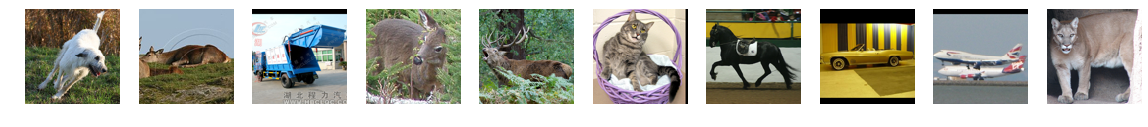

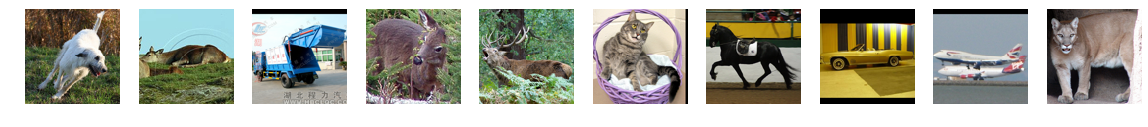

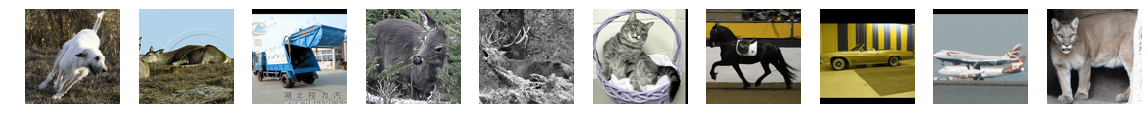

In [116]:
# show s u v
test_images_flat = np.reshape(test_images,(10,96*96,3))
s,U,V   = tf.svd(test_images_flat)
smin    = tf.reduce_min(s,1,keepdims=True)
smax    = tf.reduce_max(s,1,keepdims=True)
mmax =  0.05
mmin =  0
scaleds = (mmax-mmin)*(s - smin)/(smax - smin + 1e-8) + mmin
recon1 = U @ tf.matrix_diag(s)       @ tf.transpose(V,(0,2,1))
recon1 = recon1 * tf.reduce_mean(tf.transpose(tf.abs(V),(0,2,1)) * ,(1),keepdims=True)
recon2 = U[:,:,:] @ tf.matrix_diag(scaleds[:,:]) @ tf.transpose(V,(0,2,1))[:,:,:]
recon1 = recon1.eval()
recon2 = recon2.eval()
recon1_reshape = np.reshape(recon1,(10,96,96,3))
recon2_reshape = np.reshape(recon2,(10,96,96,3))

print(recon1_reshape.shape)
print(recon2_reshape.shape)
print(np.allclose(recon1,test_images_flat))
print(np.allclose(recon2,test_images_flat))

recon1_reshape = (recon1_reshape-recon1_reshape.min((1,2),keepdims=True))/(recon1_reshape.max((1,2),keepdims=True)-recon1_reshape.min((1,2),keepdims=True))
recon2_reshape = (recon2_reshape-recon2_reshape.min((1,2),keepdims=True))/(recon2_reshape.max((1,2),keepdims=True)-recon2_reshape.min((1,2),keepdims=True))

show(test_images)
show(recon1_reshape)
show(recon2_reshape)

In [110]:
print(test_images.mean((0,1,2)))
print(test_images.std ((0,1,2)))
print(recon1_reshape.mean((0,1,2)))
print(recon1_reshape.std ((0,1,2)))
print(recon2_reshape.mean((0,1,2)))
print(recon2_reshape.std ((0,1,2)))

[0.48688113 0.48579878 0.42157484]
[0.24729228 0.2429821  0.27573131]
[0.48216067 0.48538282 0.42215459]
[0.25147739 0.25827502 0.28740009]
[0.47401969 0.47619256 0.43790244]
[0.24836926 0.25524647 0.27823375]


In [111]:
print(test_images.sum((1,2,3)))
print(recon1_reshape.sum((1,2,3)))
print(recon2_reshape.sum((1,2,3)))

[10032.34117647 13010.41960784 15966.13333333 13154.9372549
 10812.16470588 17473.74901961  9085.8745098   9041.09411765
 15225.64313725 14692.16078431]
[ 9803.14777255 14401.68037276 15966.13333333 11594.27871905
 12076.84444189 17473.74901961  8706.71654989  9103.2510128
 15410.46918111 13538.30469759]
[ 9745.68340283 14525.881046   15848.45662951 11200.04975528
 12380.36098692 17502.23855722  8674.51871421  9065.97240196
 15463.52976702 13521.95902832]
